# Policy Gradients
### Introduction
On this notebook we will train a policy network to solve a particular problem on the OpenAI Environment. We will train this policy network with the REINFORCE algorithm.
![alt text](imgs/policy_stochastic.png "Game")

#### REINFORCE Algorithm
#### Short Introduction
The REINFORCE algorithm is one implementation of the Policy Gradient family of algorithms, the idea of the algorithm is to have the policy represented by a neural network with $\theta$ parameters. The main idea of the algorithm is to change the network parameters to make the actions that provided positive rewards to be more probable to happen. The training phase optimize the following loss function:
$$\mathcal{L}=-\hat{Q}(s,a).log\pi_{\theta}(a|s)$$
Where:
* $\hat{Q}(s,a)$: It's an estimate of the state action function, that will modulate the probability of good actions to happen more often.
* $\pi_{\theta}(a|s)$: It's the neural network that represent the policy and returns an distribution of actions given an state.

The steps of the algorithm
1. Initialize Network at random
2. Play N episodes saving their transitions "k" (s,a,r,s')
3. For every episode calculate $\hat{Q}(s,a)=\sum_{i=0} \gamma^i r_i$
4. Perform SGD to minimize the loss: $\mathcal{L}=-\hat{Q}(s,a).log\pi_{\theta}(a|s)$
5. Repeat 2 until convergence 

#### Disadvantages of Policy Gradients
* Full episodes are required, we need to wait a full episode to complete
* High Gradients Variance: This issue can be handled by subtracting a baseline from the Value estimation
* Exploration: The agent can converge to a local-optimal area and won't explore efficiently anymore. This can be solved by the Entropy Bonus technique that basically subtract the entropy of the policy from the loss function.
* Correlation between samples: This can be remedy by using parallel environments with same policy and using the experiences from different environments to train the policy.
* Less sample efficient: To deal with this we need another algorithm (Actor-Critic)

The image bellow can highlight the full episodic issue, where we have 2 trajectories where one or more actions could be bad, but as the final total score is good those bad actions will be averaged. That's one of the reasons why Policy Gradient methods are less sample efficient.
![alt text](imgs/episode_problem.png "Game")

#### Cartpole Rules
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

#### References
* https://www.youtube.com/watch?v=tqrcjHuNdmQ
* http://karpathy.github.io/2016/05/31/rl/
* https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf
* https://leimao.github.io/article/REINFORCE-Policy-Gradient/
* https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c
* https://medium.freecodecamp.org/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f
* https://gist.github.com/tamlyn/a9d2b3990f9dab0f82d1dfc1588c876a
* http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/
* https://www.youtube.com/watch?v=iOh7QUZGyiU&list=PLqYmG7hTraZDNJre23vqCGIVpfZ_K2RZs
* https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html
* https://medium.com/@gabogarza/deep-reinforcement-learning-policy-gradients-8f6df70404e6
* https://towardsdatascience.com/learning-to-drive-smoothly-in-minutes-450a7cdb35f4
* http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf
* https://fosterelli.co/entropy-loss-for-reinforcement-learning

### Import Libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

### Initialize Environment and Hyper parameters

In [2]:
env = gym.make('CartPole-v1')
# Uncomment for this environment (takes longer to train)
#env = gym.make('LunarLander-v2')
env.seed(1)
torch.manual_seed(1)

# Hyperparameters
learning_rate = 0.01
entropy_beta = 0.01
gamma = 0.99
num_episodes=1500

# Show some information from the environment
print('Amount of rewards consider as win:', env.spec.reward_threshold)
print('Action space:', env.action_space.n)
print('Observation space:', env.observation_space.shape)
print('Reward range:', env.reward_range)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Amount of rewards consider as win: 475.0
Action space: 2
Observation space: (4,)
Reward range: (-inf, inf)


/Users/leonardo_a/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Policy Network
Define the policy Neural Network, which inputs will be the state and output an action

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 128

        self.FC1 = nn.Linear(state_space, num_hidden, bias=False)
        self.FC2 = nn.Linear(num_hidden, action_space, bias=False)

        # Overall reward and loss history (Just for plotting training information)
        self.reward_history = []
        self.loss_history = []
        self.reset()

    def reset(self):
        # Episode policy log probability(action) and reward history
        self.episode_log_prob_actions = torch.Tensor([])
        self.episode_log_prob_actions_dist = torch.Tensor([])
        self.episode_prob_actions = torch.Tensor([])
        self.episode_rewards = []

    def forward(self, x, keep_history=False):
        # Convert state to tensor
        state = torch.from_numpy(x).type(torch.FloatTensor)
        model = torch.nn.Sequential(
            self.FC1,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.FC2,
            nn.Softmax(dim=-1)
        )
        
        # Execute model and sample it's outputs
        action_probs = model(state)
        distribution = Categorical(action_probs)
        action = distribution.sample()
        
        #print('action_probs:', action_probs.size())
        #print('distribution.log_prob:', distribution.log_prob(action).size())
        #print('F.log_prob(action_probs):', torch.log(action_probs).size())
        
        # Concatenate log probability of the action to be used on the loss function
        if keep_history:
            self.episode_log_prob_actions = torch.cat([self.episode_log_prob_actions, 
                                                     distribution.log_prob(action).reshape(1)])
            self.episode_log_prob_actions_dist = torch.cat([self.episode_log_prob_actions_dist, 
                                                     torch.log(action_probs)])
            self.episode_prob_actions = torch.cat([self.episode_prob_actions, action_probs])
        
        return action.item()

In [4]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

### Define the update policy function
This function is called after we gather a complete episode, and it does the following tasks:
1. Calculate the discounted Rewards: $\hat{Q}(s,a)=\sum_{i=0} \gamma^i r_i$
2. Calculate the baseline (rewards mean) and normalize the discounted rewards
3. Calculate the entropy loss (Optional)
4. Calculate the Policy loss
5. Calculate the complete loss
6. Do the loss backpropagation (Pytorch)

In [5]:
def update_policy(use_baseline = False, use_entropy = False):
    R = 0
    rewards = []

    # Discount future rewards starting from the most recent reward backwards
    for r in reversed(policy.episode_rewards):
        R = r + gamma * R
        rewards.insert(0, R)

    # Scale rewards to make the advantage be 1/-1 (Zero-mean Unit variance)
    # This is one of multiple ways to implement the advantage, for example if you use another network
    # to learn the advantage this will become the actor-critic algorithm.
    rewards = torch.FloatTensor(rewards)
    
    if use_baseline:
        baseline = rewards.mean()
        # Calculate the value estimation with a baseline (Without the baseline will be harder to converge)
        Q_estim = (rewards - baseline) / (rewards.std() + np.finfo(np.float32).eps)
    else:
        Q_estim = rewards

    # Calculate the entropy 
    entropy_loss = -entropy_beta * (torch.sum(policy.episode_prob_actions * policy.episode_log_prob_actions_dist))
    
    # Calculate the policy loss
    police_loss = torch.sum(-Q_estim * policy.episode_log_prob_actions)
    
    if use_entropy:
        # Calculate loss log_prob(action) * rewards
        loss = police_loss - entropy_loss    
    else:
        loss = police_loss

    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save and intialize episode history counters
    policy.loss_history.append(loss.item())
    policy.reward_history.append(np.sum(policy.episode_rewards))
    policy.reset()

### Check untrained Policy

In [6]:
state = env.reset()

for time in range(50):
    # Get an action from the Policy
    action = policy(state)

    # Render screen
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


### Train on the Environment

In [7]:
%%time
length_episode = []
rewards_episode = []
for episode in range(num_episodes):
    # Reset environment and record the starting state
    state = env.reset()

    for time in range(1000):
        # Get an action from the Policy and keep the historical data
        action = policy(state, keep_history=True)

        # Step through environment using chosen action
        state, reward, done, _ = env.step(action)

        # Save reward
        policy.episode_rewards.append(reward)
        rewards_episode.append(reward)
        if done:
            break

    # Calculate score to determine when the environment has been solved
    length_episode.append(time)
    mean_length_episode = np.mean(length_episode[-100:])
    mean_rewards_episode = np.mean(rewards_episode)
    
    # Calculate the discounted rewards on the episode, calculate loss and backpropagate
    update_policy()

    if episode % 50 == 0:
        print('Episode {}\tAverage length (last 100 episodes): {:.2f} Average Rewards {:.2f}'.format(
            episode, mean_length_episode, mean_rewards_episode))

    if mean_length_episode > env.spec.reward_threshold:
        print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
              .format(episode, mean_length_episode, time))
        # Stop training after solving the environment
        #break

Episode 0	Average length (last 100 episodes): 13.00 Average Rewards 1.00
Episode 50	Average length (last 100 episodes): 32.61 Average Rewards 1.00
Episode 100	Average length (last 100 episodes): 120.82 Average Rewards 1.00
Episode 150	Average length (last 100 episodes): 196.67 Average Rewards 1.00
Episode 200	Average length (last 100 episodes): 214.13 Average Rewards 1.00
Episode 250	Average length (last 100 episodes): 367.47 Average Rewards 1.00
Episode 300	Average length (last 100 episodes): 460.44 Average Rewards 1.00
Episode 350	Average length (last 100 episodes): 464.25 Average Rewards 1.00
Solved after 382 episodes! Running average is now 476.07. Last episode ran to 499 time steps.
Solved after 383 episodes! Running average is now 476.07. Last episode ran to 499 time steps.
Solved after 384 episodes! Running average is now 475.71. Last episode ran to 463 time steps.
Solved after 385 episodes! Running average is now 476.28. Last episode ran to 499 time steps.
Solved after 386 epis

Solved after 462 episodes! Running average is now 479.67. Last episode ran to 499 time steps.
Solved after 463 episodes! Running average is now 480.65. Last episode ran to 499 time steps.
Solved after 464 episodes! Running average is now 482.19. Last episode ran to 499 time steps.
Solved after 465 episodes! Running average is now 482.19. Last episode ran to 499 time steps.
Solved after 466 episodes! Running average is now 482.19. Last episode ran to 499 time steps.
Solved after 467 episodes! Running average is now 482.19. Last episode ran to 499 time steps.
Solved after 468 episodes! Running average is now 484.21. Last episode ran to 499 time steps.
Solved after 469 episodes! Running average is now 486.74. Last episode ran to 499 time steps.
Solved after 470 episodes! Running average is now 487.44. Last episode ran to 499 time steps.
Solved after 471 episodes! Running average is now 488.35. Last episode ran to 499 time steps.
Solved after 472 episodes! Running average is now 490.24. La

Episode 550	Average length (last 100 episodes): 499.00 Average Rewards 1.00
Solved after 550 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 551 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 552 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 553 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 554 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 555 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 556 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 557 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 558 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 559 episodes! Running average is now 499.0. Last episode ran to 499 time s

Solved after 637 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 638 episodes! Running average is now 498.69. Last episode ran to 468 time steps.
Solved after 639 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 640 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 641 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 642 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 643 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 644 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 645 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 646 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 647 episodes! Running average is now 498.69. Las

Solved after 723 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 724 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 725 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 726 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 727 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 728 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 729 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 730 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 731 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 732 episodes! Running average is now 498.69. Last episode ran to 499 time steps.
Solved after 733 episodes! Running average is now 498.69. La

Episode 850	Average length (last 100 episodes): 411.38 Average Rewards 1.00
Episode 900	Average length (last 100 episodes): 361.20 Average Rewards 1.00
Episode 950	Average length (last 100 episodes): 436.28 Average Rewards 1.00
Solved after 975 episodes! Running average is now 476.52. Last episode ran to 499 time steps.
Solved after 976 episodes! Running average is now 478.52. Last episode ran to 499 time steps.
Solved after 977 episodes! Running average is now 481.74. Last episode ran to 499 time steps.
Solved after 978 episodes! Running average is now 481.74. Last episode ran to 499 time steps.
Solved after 979 episodes! Running average is now 483.19. Last episode ran to 499 time steps.
Solved after 980 episodes! Running average is now 485.56. Last episode ran to 499 time steps.
Solved after 981 episodes! Running average is now 488.17. Last episode ran to 499 time steps.
Solved after 982 episodes! Running average is now 488.17. Last episode ran to 499 time steps.
Solved after 983 epi

Solved after 1325 episodes! Running average is now 490.18. Last episode ran to 499 time steps.
Solved after 1326 episodes! Running average is now 490.18. Last episode ran to 499 time steps.
Solved after 1327 episodes! Running average is now 490.18. Last episode ran to 499 time steps.
Solved after 1328 episodes! Running average is now 490.18. Last episode ran to 499 time steps.
Solved after 1329 episodes! Running average is now 491.27. Last episode ran to 499 time steps.
Solved after 1330 episodes! Running average is now 491.27. Last episode ran to 499 time steps.
Solved after 1331 episodes! Running average is now 488.47. Last episode ran to 219 time steps.
Solved after 1332 episodes! Running average is now 485.53. Last episode ran to 205 time steps.
Solved after 1333 episodes! Running average is now 485.53. Last episode ran to 499 time steps.
Solved after 1334 episodes! Running average is now 485.53. Last episode ran to 499 time steps.
Solved after 1335 episodes! Running average is now

### Plot Training information

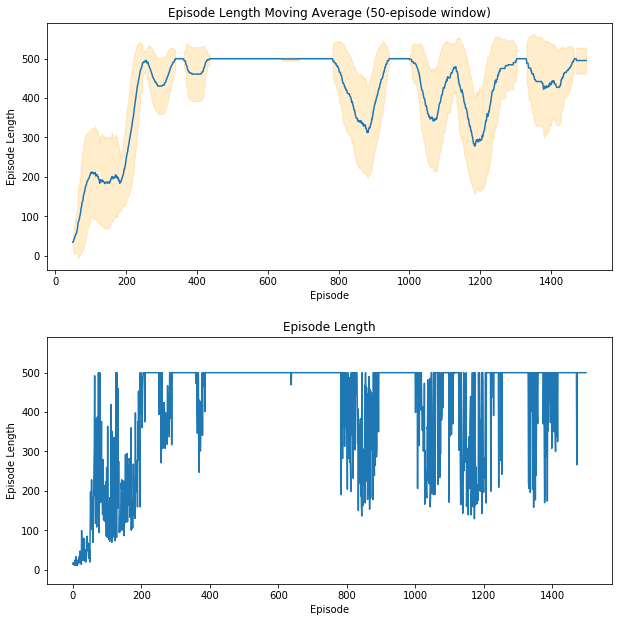

In [8]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()


### Test the Trained Policy

In [9]:
state = env.reset()

for time in range(1000):
    action = policy(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    if done:
        break

### Improving sample efficiency
Policy Gradient algorithms are already sample-efficiency worse than value based algorithms. Calculating a baseline and subtracting from your value estimate $\hat{Q}$ will improve sample efficiency. Here is a list of poossible choices for baselines:
* Some constant value, for example the mean of the discounted rewards
* Moving average of discounted rewards
* Value of state V(s)
Also depending if we use anohter network to learn out baseline we will be working on the Actor-Critic family o algorithms.

In [10]:
%%time
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

length_episode = []
rewards_episode = []
for episode in range(num_episodes):
    # Reset environment and record the starting state
    state = env.reset()

    for time in range(1000):
        # Get an action from the Policy and keep the historical data
        action = policy(state, keep_history=True)

        # Step through environment using chosen action
        state, reward, done, _ = env.step(action)

        # Save reward
        policy.episode_rewards.append(reward)
        rewards_episode.append(reward)
        if done:
            break

    # Calculate score to determine when the environment has been solved
    length_episode.append(time)
    mean_length_episode = np.mean(length_episode[-100:])
    mean_rewards_episode = np.mean(rewards_episode)
    
    # Calculate the discounted rewards on the episode, calculate loss and backpropagate
    update_policy(use_baseline=True)

    if episode % 50 == 0:
        print('Episode {}\tAverage length (last 100 episodes): {:.2f} Average Rewards {:.2f}'.format(
            episode, mean_length_episode, mean_rewards_episode))

    if mean_length_episode > env.spec.reward_threshold:
        print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
              .format(episode, mean_length_episode, time))
        # Stop training after solving the environment
        #break

Episode 0	Average length (last 100 episodes): 10.00 Average Rewards 1.00
Episode 50	Average length (last 100 episodes): 53.98 Average Rewards 1.00
Episode 100	Average length (last 100 episodes): 72.02 Average Rewards 1.00
Episode 150	Average length (last 100 episodes): 124.39 Average Rewards 1.00
Episode 200	Average length (last 100 episodes): 195.90 Average Rewards 1.00
Episode 250	Average length (last 100 episodes): 278.55 Average Rewards 1.00
Episode 300	Average length (last 100 episodes): 386.15 Average Rewards 1.00
Episode 350	Average length (last 100 episodes): 466.16 Average Rewards 1.00
Solved after 357 episodes! Running average is now 477.28. Last episode ran to 499 time steps.
Solved after 358 episodes! Running average is now 479.91. Last episode ran to 499 time steps.
Solved after 359 episodes! Running average is now 480.52. Last episode ran to 499 time steps.
Solved after 360 episodes! Running average is now 482.86. Last episode ran to 499 time steps.
Solved after 361 episo

Solved after 1082 episodes! Running average is now 496.92. Last episode ran to 499 time steps.
Solved after 1083 episodes! Running average is now 497.22. Last episode ran to 499 time steps.
Solved after 1084 episodes! Running average is now 497.22. Last episode ran to 499 time steps.
Solved after 1085 episodes! Running average is now 498.53. Last episode ran to 499 time steps.
Solved after 1086 episodes! Running average is now 498.53. Last episode ran to 499 time steps.
Solved after 1087 episodes! Running average is now 498.6. Last episode ran to 499 time steps.
Solved after 1088 episodes! Running average is now 498.6. Last episode ran to 499 time steps.
Solved after 1089 episodes! Running average is now 498.6. Last episode ran to 499 time steps.
Solved after 1090 episodes! Running average is now 498.6. Last episode ran to 499 time steps.
Solved after 1091 episodes! Running average is now 498.6. Last episode ran to 499 time steps.
Solved after 1092 episodes! Running average is now 498.

Solved after 1313 episodes! Running average is now 476.68. Last episode ran to 499 time steps.
Solved after 1314 episodes! Running average is now 476.68. Last episode ran to 499 time steps.
Solved after 1315 episodes! Running average is now 478.88. Last episode ran to 499 time steps.
Solved after 1316 episodes! Running average is now 479.94. Last episode ran to 499 time steps.
Solved after 1317 episodes! Running average is now 480.16. Last episode ran to 499 time steps.
Solved after 1318 episodes! Running average is now 481.84. Last episode ran to 499 time steps.
Solved after 1319 episodes! Running average is now 483.52. Last episode ran to 499 time steps.
Solved after 1320 episodes! Running average is now 485.36. Last episode ran to 499 time steps.
Solved after 1321 episodes! Running average is now 486.48. Last episode ran to 499 time steps.
Solved after 1322 episodes! Running average is now 486.48. Last episode ran to 499 time steps.
Solved after 1323 episodes! Running average is now

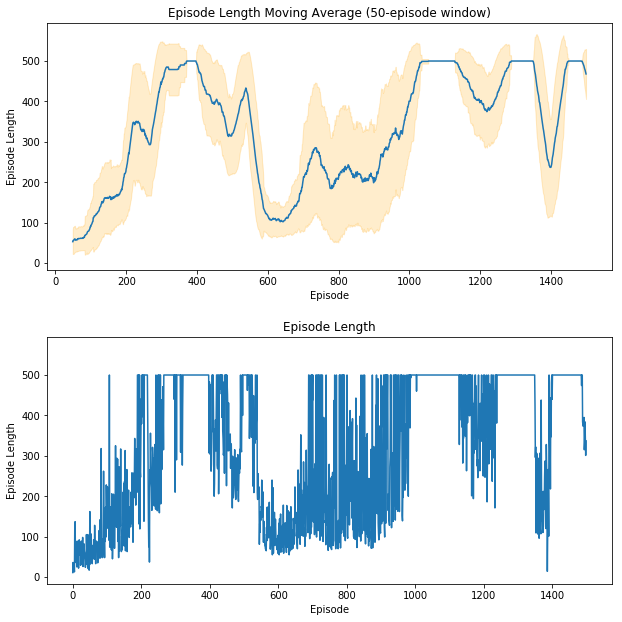

In [11]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

### Improving Exploration/Exploitation
In order to avoid the policy to conferge fast and stop exploring (Get stuck in local minima) in the environment, there is a trick called entropy bonus.
$$H(\pi)=-\sum{\pi_{\theta}(a|s).log\pi_{\theta}(a|s)}$$
This will simply show how much uncertain the policy is about it's actions. 
We just need to subtract the entropy bons from the loss function, forcing the policy to take more time to be certain and exploring more.

In [12]:
%%time
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

length_episode = []
rewards_episode = []
for episode in range(num_episodes):
    # Reset environment and record the starting state
    state = env.reset()

    for time in range(1000):
        # Get an action from the Policy and keep the historical data
        action = policy(state, keep_history=True)

        # Step through environment using chosen action
        state, reward, done, _ = env.step(action)

        # Save reward
        policy.episode_rewards.append(reward)
        rewards_episode.append(reward)
        if done:
            break

    # Calculate score to determine when the environment has been solved
    length_episode.append(time)
    mean_length_episode = np.mean(length_episode[-100:])
    mean_rewards_episode = np.mean(rewards_episode)
    
    # Calculate the discounted rewards on the episode, calculate loss and backpropagate
    update_policy(use_baseline=True, use_entropy=True)

    if episode % 50 == 0:
        print('Episode {}\tAverage length (last 100 episodes): {:.2f} Average Rewards {:.2f}'.format(
            episode, mean_length_episode, mean_rewards_episode))

    if mean_length_episode > env.spec.reward_threshold:
        print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
              .format(episode, mean_length_episode, time))
        # Stop training after solving the environment
        #break

Episode 0	Average length (last 100 episodes): 36.00 Average Rewards 1.00
Episode 50	Average length (last 100 episodes): 71.27 Average Rewards 1.00
Episode 100	Average length (last 100 episodes): 158.49 Average Rewards 1.00
Episode 150	Average length (last 100 episodes): 301.56 Average Rewards 1.00
Episode 200	Average length (last 100 episodes): 260.66 Average Rewards 1.00
Episode 250	Average length (last 100 episodes): 280.57 Average Rewards 1.00
Episode 300	Average length (last 100 episodes): 412.64 Average Rewards 1.00
Episode 350	Average length (last 100 episodes): 380.47 Average Rewards 1.00
Episode 400	Average length (last 100 episodes): 251.43 Average Rewards 1.00
Episode 450	Average length (last 100 episodes): 180.01 Average Rewards 1.00
Episode 500	Average length (last 100 episodes): 245.22 Average Rewards 1.00
Episode 550	Average length (last 100 episodes): 325.60 Average Rewards 1.00
Episode 600	Average length (last 100 episodes): 398.01 Average Rewards 1.00
Episode 650	Avera

Episode 750	Average length (last 100 episodes): 461.30 Average Rewards 1.00
Episode 800	Average length (last 100 episodes): 455.44 Average Rewards 1.00
Solved after 836 episodes! Running average is now 476.2. Last episode ran to 499 time steps.
Solved after 837 episodes! Running average is now 477.84. Last episode ran to 499 time steps.
Solved after 838 episodes! Running average is now 477.84. Last episode ran to 499 time steps.
Solved after 839 episodes! Running average is now 477.84. Last episode ran to 499 time steps.
Solved after 840 episodes! Running average is now 480.08. Last episode ran to 499 time steps.
Solved after 841 episodes! Running average is now 480.08. Last episode ran to 499 time steps.
Solved after 842 episodes! Running average is now 481.61. Last episode ran to 499 time steps.
Solved after 843 episodes! Running average is now 481.61. Last episode ran to 499 time steps.
Solved after 844 episodes! Running average is now 481.61. Last episode ran to 499 time steps.
Sol

Solved after 921 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 922 episodes! Running average is now 499.0. Last episode ran to 499 time steps.
Solved after 923 episodes! Running average is now 496.13. Last episode ran to 212 time steps.
Solved after 924 episodes! Running average is now 496.13. Last episode ran to 499 time steps.
Solved after 925 episodes! Running average is now 496.13. Last episode ran to 499 time steps.
Solved after 926 episodes! Running average is now 496.13. Last episode ran to 499 time steps.
Solved after 927 episodes! Running average is now 496.13. Last episode ran to 499 time steps.
Solved after 928 episodes! Running average is now 496.13. Last episode ran to 499 time steps.
Solved after 929 episodes! Running average is now 493.51. Last episode ran to 237 time steps.
Solved after 930 episodes! Running average is now 493.51. Last episode ran to 499 time steps.
Solved after 931 episodes! Running average is now 493.51. Last

Solved after 1007 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1008 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1009 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1010 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1011 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1012 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1013 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1014 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1015 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1016 episodes! Running average is now 483.27. Last episode ran to 499 time steps.
Solved after 1017 episodes! Running average is now

Solved after 1093 episodes! Running average is now 488.69. Last episode ran to 499 time steps.
Solved after 1094 episodes! Running average is now 488.69. Last episode ran to 499 time steps.
Solved after 1095 episodes! Running average is now 488.69. Last episode ran to 499 time steps.
Solved after 1096 episodes! Running average is now 488.69. Last episode ran to 499 time steps.
Solved after 1097 episodes! Running average is now 488.69. Last episode ran to 499 time steps.
Solved after 1098 episodes! Running average is now 484.97. Last episode ran to 127 time steps.
Solved after 1099 episodes! Running average is now 484.97. Last episode ran to 499 time steps.
Episode 1100	Average length (last 100 episodes): 484.97 Average Rewards 1.00
Solved after 1100 episodes! Running average is now 484.97. Last episode ran to 499 time steps.
Solved after 1101 episodes! Running average is now 484.97. Last episode ran to 499 time steps.
Solved after 1102 episodes! Running average is now 484.97. Last epis

Solved after 1225 episodes! Running average is now 485.18. Last episode ran to 499 time steps.
Solved after 1226 episodes! Running average is now 483.78. Last episode ran to 359 time steps.
Solved after 1227 episodes! Running average is now 483.78. Last episode ran to 499 time steps.
Solved after 1228 episodes! Running average is now 483.78. Last episode ran to 499 time steps.
Solved after 1229 episodes! Running average is now 483.78. Last episode ran to 499 time steps.
Solved after 1230 episodes! Running average is now 483.78. Last episode ran to 499 time steps.
Solved after 1231 episodes! Running average is now 483.78. Last episode ran to 499 time steps.
Solved after 1232 episodes! Running average is now 483.78. Last episode ran to 499 time steps.
Solved after 1233 episodes! Running average is now 483.78. Last episode ran to 499 time steps.
Solved after 1234 episodes! Running average is now 483.78. Last episode ran to 499 time steps.
Solved after 1235 episodes! Running average is now

Solved after 1310 episodes! Running average is now 483.79. Last episode ran to 499 time steps.
Solved after 1311 episodes! Running average is now 483.79. Last episode ran to 499 time steps.
Solved after 1312 episodes! Running average is now 483.79. Last episode ran to 499 time steps.
Solved after 1313 episodes! Running average is now 485.01. Last episode ran to 499 time steps.
Solved after 1314 episodes! Running average is now 485.01. Last episode ran to 499 time steps.
Solved after 1315 episodes! Running average is now 485.01. Last episode ran to 499 time steps.
Solved after 1316 episodes! Running average is now 485.01. Last episode ran to 499 time steps.
Solved after 1317 episodes! Running average is now 485.06. Last episode ran to 499 time steps.
Solved after 1318 episodes! Running average is now 489.91. Last episode ran to 499 time steps.
Solved after 1319 episodes! Running average is now 493.17. Last episode ran to 499 time steps.
Solved after 1320 episodes! Running average is now

Solved after 1397 episodes! Running average is now 493.09. Last episode ran to 499 time steps.
Solved after 1398 episodes! Running average is now 493.09. Last episode ran to 499 time steps.
Solved after 1399 episodes! Running average is now 493.09. Last episode ran to 499 time steps.
Episode 1400	Average length (last 100 episodes): 492.83 Average Rewards 1.00
Solved after 1400 episodes! Running average is now 492.83. Last episode ran to 473 time steps.
Solved after 1401 episodes! Running average is now 492.83. Last episode ran to 499 time steps.
Solved after 1402 episodes! Running average is now 492.83. Last episode ran to 499 time steps.
Solved after 1403 episodes! Running average is now 492.83. Last episode ran to 499 time steps.
Solved after 1404 episodes! Running average is now 492.83. Last episode ran to 499 time steps.
Solved after 1405 episodes! Running average is now 492.83. Last episode ran to 499 time steps.
Solved after 1406 episodes! Running average is now 492.83. Last epis

Solved after 1482 episodes! Running average is now 476.07. Last episode ran to 499 time steps.
Solved after 1483 episodes! Running average is now 476.07. Last episode ran to 499 time steps.
Solved after 1484 episodes! Running average is now 476.07. Last episode ran to 499 time steps.
Solved after 1485 episodes! Running average is now 476.07. Last episode ran to 499 time steps.
Solved after 1486 episodes! Running average is now 476.07. Last episode ran to 499 time steps.
Solved after 1487 episodes! Running average is now 476.07. Last episode ran to 499 time steps.
Solved after 1488 episodes! Running average is now 476.07. Last episode ran to 499 time steps.
Solved after 1489 episodes! Running average is now 475.46. Last episode ran to 263 time steps.
Solved after 1490 episodes! Running average is now 475.46. Last episode ran to 499 time steps.
Solved after 1491 episodes! Running average is now 475.46. Last episode ran to 499 time steps.
Solved after 1492 episodes! Running average is now

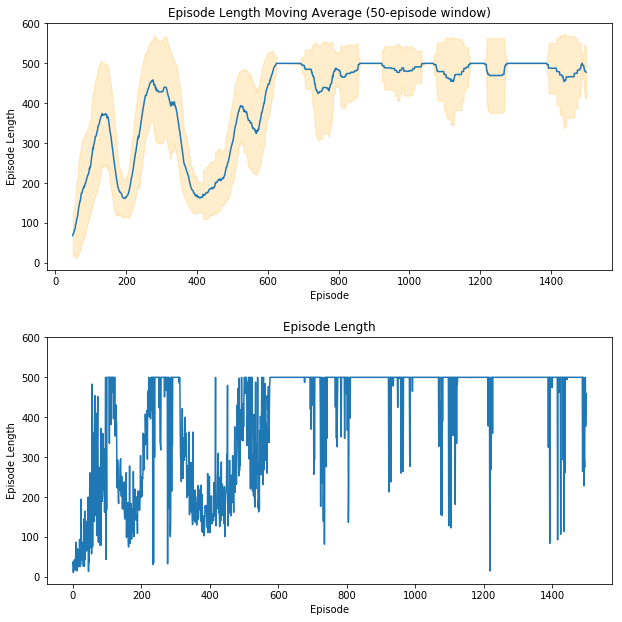

In [13]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

In [14]:
state = env.reset()

while True:
    action = policy(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    if done:
        break